<a href="https://colab.research.google.com/github/rocabrera/IA025A_2022S1/blob/master/ex04/Aula_4_Exerc%C3%ADcio_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Nome: Rodrigo Cabrera Castaldoni

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())

print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [6]:
class MyDataLoader:
    
    def __init__(self, dataset:torch.utils.data.Subset, batch_size:int, shuffle:bool=False):
        
        self.dataset = dataset
        self.dataset_size = len(dataset)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batch = int(np.ceil(self.dataset_size/batch_size))
        
    def __len__(self):
        return self.n_batch      
    
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        
        indices = self.__create_index()
        if self.n < self.n_batch:
            iter_subset = torch.utils.data.Subset(self.dataset, indices)
            images, labels = zip(*[(images, labels) for images, labels in iter_subset])
            self.n += 1
            return torch.stack(images), torch.Tensor(labels)
        else:
            raise StopIteration
            
    def __create_index(self):
        
        if self.shuffle:
            indices = torch.randperm(self.dataset_size)[self.batch_size]
        else:
            min_index = self.n * self.batch_size
            theoretical_max = (self.n + 1) * self.batch_size
            max_index = self.dataset_size if theoretical_max > self.dataset_size else theoretical_max
            indices = torch.arange(min_index, max_index)
        
        return indices

In [7]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
loader_train = MyDataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=False)

In [8]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [9]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class Model:
    def __init__(self, n_in: int, n_out: int):
        # +1 para o bias
        self.weights = torch.zeros(n_in+1, n_out, requires_grad=True)
        
    def __call__(self, x):
        # Escreva seu código aqui.
        
        n_rows = x.shape[0]
        ones = torch.ones(n_rows, 1)
        new_x = torch.cat([ones,x], dim=1)
        return torch.matmul(new_x, self.weights)
    
    def parameters(self):
        return self.weights
    
model = Model(28*28,10)

output = model(x_train.view(-1, 28*28))

## Treinamento

### Inicialização dos parâmetros

In [10]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [11]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

class MyCrossEntropyLoss:
    
    def __call__(self, outputs, y_train):
        
        one_hot_mapping = torch.eye(outputs.shape[1])
        y_train_encoded = torch.stack([one_hot_mapping[int(y_value)] 
                                       for y_value in y_train])
        
        logitos = self.__softmax(outputs)
        sample_loss = - torch.sum(y_train_encoded * torch.log(logitos), 1)
        return torch.mean(sample_loss)
    
    def __softmax(self, A):
        
        x = torch.exp(A - A.max(1, keepdims=True).values)
        rows_sum = x.sum(axis=1, keepdims=True)
        return x / rows_sum # only difference

criterion = MyCrossEntropyLoss()

tensor(2.3026, grad_fn=<MeanBackward0>)

# Definição do Optimizer

In [12]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)
class MySGD:
    
    def __init__(self, parameters, lr):
        self.parameters = parameters
        self.lr = lr   
        
    def step(self):
        self.parameters.data = self.parameters.data - self.parameters.grad*self.lr
        
    def zero_grad(self):
        self.parameters.grad = torch.zeros_like(self.parameters.data)
        
optimizer = MySGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [13]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)
        # calcula a perda
        loss = criterion(outputs, y_train)
        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786613464355
Epoch: 3/49 Loss: 0.6381281018257141
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.4786270260810852
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.43632179498672485
Epoch: 10/49 Loss: 0.4191649556159973
Epoch: 11/49 Loss: 0.403904527425766
Epoch: 12/49 Loss: 0.3901680111885071
Epoch: 13/49 Loss: 0.3776799440383911
Epoch: 14/49 Loss: 0.3662315011024475
Epoch: 15/49 Loss: 0.35566142201423645
Epoch: 16/49 Loss: 0.34584277868270874
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.32807353138923645
Epoch: 19/49 Loss: 0.31997355818748474
Epoch: 20/49 Loss: 0.312318354845047
Epoch: 21/49 Loss: 0.30506110191345215
Epoch: 22/49 Loss: 0.2981624901294708
Epoch: 23/49 Loss: 0.2915884852409363
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.2793029844760895
Epoch: 26/49 Loss

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

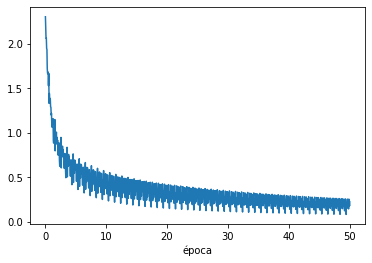

In [14]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

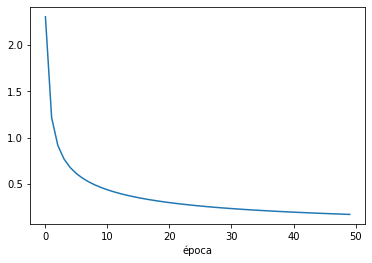

In [15]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [16]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

In [17]:
# Escreva o código aqui:
all_data = MyDataLoader(dataset=dataset_train, batch_size=len(dataset_train), shuffle=False)
x_train, y_train = next(iter(all_data))
outputs = model(x_train.view(-1,28*28))

In [18]:
logitos = criterion._MyCrossEntropyLoss__softmax(outputs)

In [19]:
max_values = torch.max(logitos,1)
y_pred_probas = max_values.values
y_pred = max_values.indices
sample_number = torch.arange(0,1000)

**Escreva um código que responda às seguintes perguntas:**


**Qual é a amostra classificada corretamente, com maior probabilidade?**

A amostra classificada corretamente com maior probabilidade: 183 com probabilidade de 0.9999896287918091
y_pred: 2
y_true: 2.0


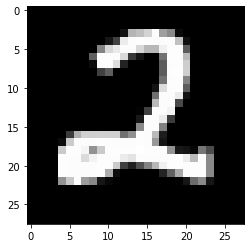

In [20]:
correct_classified = y_pred == y_train
most_correct_sample = int(torch.argmax(y_pred_probas[correct_classified]))
indice_sample = sample_number[correct_classified][most_correct_sample]
print(f"A amostra classificada corretamente com maior probabilidade: {indice_sample} com probabilidade de {y_pred_probas[indice_sample]}")
print(f"y_pred: {y_pred[indice_sample]}")
print(f"y_true: {y_train[indice_sample]}")
plt.imshow(x_train[indice_sample].squeeze(),cmap="gray")
plt.show()

**Qual é a amostra classificada corretamente, com menor probabilidade?**

A amostra classificada corretamente com menor probabilidade: 532 com probabilidade de 0.33532676100730896
y_pred: 2
y_true: 2.0


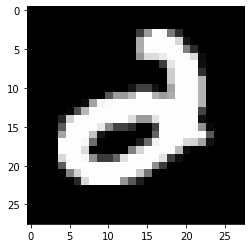

In [21]:
most_correct_sample = int(torch.argmin(y_pred_probas[correct_classified]))
indice_sample = sample_number[correct_classified][most_correct_sample]
print(f"A amostra classificada corretamente com menor probabilidade: {indice_sample} com probabilidade de {y_pred_probas[indice_sample]}")
print(f"y_pred: {y_pred[indice_sample]}")
print(f"y_true: {y_train[indice_sample]}")
plt.imshow(x_train[indice_sample].squeeze(),cmap="gray")
plt.show()

**Qual é a amostra classificada erradamente, com maior probabilidade?**

A amostra classificada erroneamente com maior probabilidade: 271 com probabilidade de 0.8530497550964355
y_pred: 8
y_true: 3.0


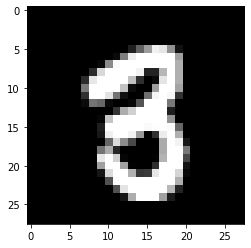

In [22]:
correct_classified = y_pred != y_train
most_correct_sample = int(torch.argmax(y_pred_probas[correct_classified]))
indice_sample = sample_number[correct_classified][most_correct_sample]
print(f"A amostra classificada erroneamente com maior probabilidade: {indice_sample} com probabilidade de {y_pred_probas[indice_sample]}")
print(f"y_pred: {y_pred[indice_sample]}")
print(f"y_true: {y_train[indice_sample]}")
plt.imshow(x_train[indice_sample].squeeze(),cmap="gray")
plt.show()

Qual é a amostra classificada erradamente, com menor probabilidade?

A amostra classificada erroneamente com menor probabilidade: 68 com probabilidade de 0.2892139256000519
y_pred: 8
y_true: 5.0


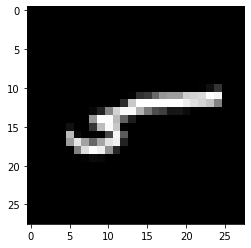

In [23]:
most_correct_sample = int(torch.argmin(y_pred_probas[correct_classified]))
indice_sample = sample_number[correct_classified][most_correct_sample]
print(f"A amostra classificada erroneamente com menor probabilidade: {indice_sample} com probabilidade de {y_pred_probas[indice_sample]}")
print(f"y_pred: {y_pred[indice_sample]}")
print(f"y_true: {y_train[indice_sample]}")
plt.imshow(x_train[indice_sample].squeeze(),cmap="gray")
plt.show()

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.


In [24]:
import random
import pandas as pd


class MyCustomDataLoader:

    """
    Nesta implementação uma mesma imagem pode aparecer 2 vezes no mesmo batch.
    """
    
    def __init__(self, dataset:torch.utils.data.Subset, batch_size:int, shuffle:bool=False):
        
        self.dataset = dataset
        self.dataset_size = len(dataset)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batch = int(np.ceil(self.dataset_size/batch_size))
        self.__prepare_custom_batch()
        
    def __prepare_custom_batch(self):
        self.n_classes = 10
        self.proba_list = [0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
        self.output_classes_structure = {i:[] for i in range(self.n_classes)}
        
        for images, label in self.dataset:
            self.output_classes_structure[label].append(images)
            
    def __len__(self):
        return self.n_batch      
    
    def __iter__(self):
        self.n = 0
        return self
         
    def __next__(self):
    
        if self.n < self.n_batch:

            weighted_labels = random.choices(population=list(self.output_classes_structure.keys()),
                                             weights=self.proba_list,
                                             k=self.batch_size)
            images, labels = zip(*[(random.sample(self.output_classes_structure[label], 1)[0], label) for label in weighted_labels])
        
            self.n += 1
            
            return torch.stack(images), torch.Tensor(labels)
        
        else:
            raise StopIteration

In [25]:
# podemos ver que 2 é majoritário, seguido de 3
aux = 0
custom_loader_train = MyCustomDataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=False)
for idx, (images, labels) in enumerate(custom_loader_train):
    print(f"Batch número {idx}")
    print(pd.Series(labels.tolist()).value_counts(normalize=True))
    print("#"*32)
    if aux >= 2:
        break
    aux+=1

Batch número 0
2.0    0.74
3.0    0.24
0.0    0.02
dtype: float64
################################
Batch número 1
2.0    0.70
3.0    0.22
5.0    0.04
0.0    0.02
6.0    0.02
dtype: float64
################################
Batch número 2
2.0    0.68
3.0    0.28
7.0    0.02
4.0    0.02
dtype: float64
################################


In [26]:
# Se aumentarmos o batch as probabilidades da classe se aproximam da distribuição passada.
aux = 0
custom_loader_train = MyCustomDataLoader(dataset=dataset_train, batch_size=400, shuffle=False)
for idx, (images, labels) in enumerate(custom_loader_train):
    print(f"Batch número {idx}")
    print(pd.Series(labels.tolist()).value_counts(normalize=True))
    print("#"*32)
    if aux >= 2:
        break
    aux+=1

Batch número 0
2.0    0.7150
3.0    0.2075
8.0    0.0150
7.0    0.0150
0.0    0.0125
4.0    0.0100
5.0    0.0100
1.0    0.0075
9.0    0.0050
6.0    0.0025
dtype: float64
################################
Batch número 1
2.0    0.6975
3.0    0.2200
4.0    0.0150
6.0    0.0150
7.0    0.0150
5.0    0.0100
0.0    0.0100
1.0    0.0100
8.0    0.0075
dtype: float64
################################
Batch número 2
2.0    0.7325
3.0    0.1975
1.0    0.0150
8.0    0.0125
6.0    0.0100
9.0    0.0100
7.0    0.0100
0.0    0.0075
4.0    0.0025
5.0    0.0025
dtype: float64
################################
